In [1]:
import os
import fitsio

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
datadir = '/global/cfs/cdirs/lsst/groups/PZ/HSCDATA/'
datadir_des = '/global/cfs/projectdirs/des/www/y3_cats/'
outdir = '/global/cfs/projectdirs/des/jmyles/sompz_desc/'
if not os.path.exists(outdir):
    os.system('mkdir -p ' + outdir)
    
#infile_deep = os.path.join(datadir, 'GAMA09H_calibrated_pz.fits')
infile_specz_dud = os.path.join(datadir, 'SPECTROSCOPY','223501_specz_match_summary_pdr3_dud.fits')
infile_specz_wide = os.path.join(datadir, 'SPECTROSCOPY','223502_specz_match_summary_pdr3_wide.fits')

# see also https://cdcvs.fnal.gov/redmine/projects/des-sci-release/wiki/Y3_deep_fields_cat
infile_jhk_des = os.path.join(datadir_des, 'run-JHK-mof02_ff04_ff02_extcorr_24Apr20.fits')
infile_ugriz_des = os.path.join(datadir_des, 'run-ugriz-mof02_extcorr_24Apr20.fits')

outfile = os.path.join(outdir, 'hsc_deep_incl_nir_incl_specz_TEST_ONLY_NO_SCIENCE_2023-10-17.fits')
# not good for science because
# only has galaxies with spec-z, not all deep galaxies
# does catalog matching rather than forced photometry
# etc
# 

In [3]:
specz_dud = fitsio.read(infile_specz_dud)
specz_wide = fitsio.read(infile_specz_wide)

jhk_des = fitsio.read(infile_jhk_des)
ugriz_des = fitsio.read(infile_ugriz_des)

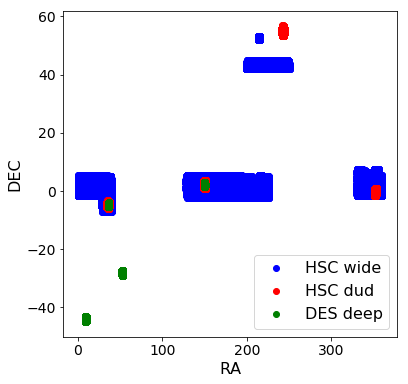

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(specz_wide['specz_ra'], specz_wide['specz_dec'], 'bo', label='HSC wide', alpha=1)
ax.plot(specz_dud['specz_ra'], specz_dud['specz_dec'], 'ro', label='HSC dud', alpha=1)

ax.plot(jhk_des['ra'], jhk_des['dec'], 'go', label='DES deep', alpha=1)
ax.set_xlabel('RA', fontsize=16)
ax.set_ylabel('DEC', fontsize=16)
ax.legend(fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=14)

In [5]:
# TODO -- eventually use all deep galaxies not just ones with spectra
ra1 = specz_dud['specz_ra']
dec1 = specz_dud['specz_dec']
c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)

In [6]:
ra2 = jhk_des['ra']
dec2 = jhk_des['dec']

catalog_jhk = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog_jhk)
# Now idx are indices into catalog that are the closest objects to each of the coordinates in c
is_match_jhk = d2d < 1 * u.arcsec

In [7]:
ra2 = ugriz_des['ra']
dec2 = ugriz_des['dec']

catalog_ugriz = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog_ugriz)
# Now idx are indices into catalog that are the closest objects to each of the coordinates in c
is_match_ugriz = d2d < 1 * u.arcsec

In [8]:
new_dt = np.dtype(specz_dud.dtype.descr + [
# cluster properties
('flux_DES_DEEP_' + 'u', '>f4'),
('flux_DES_DEEP_' + 'g', '>f4'),
('flux_DES_DEEP_' + 'r', '>f4'),
('flux_DES_DEEP_' + 'i', '>f4'),
('flux_DES_DEEP_' + 'z', '>f4'),
('flux_DES_DEEP_' + 'J', '>f4'),
('flux_DES_DEEP_' + 'H', '>f4'),
('flux_DES_DEEP_' + 'K', '>f4'),
    
('mag_DES_DEEP_' + 'u', '>f4'),
('mag_DES_DEEP_' + 'g', '>f4'),
('mag_DES_DEEP_' + 'r', '>f4'),
('mag_DES_DEEP_' + 'i', '>f4'),
('mag_DES_DEEP_' + 'z', '>f4'),
('mag_DES_DEEP_' + 'J', '>f4'),
('mag_DES_DEEP_' + 'H', '>f4'),
('mag_DES_DEEP_' + 'K', '>f4'),
    
])

deep_output = np.zeros(specz_dud.shape, dtype=new_dt)

for col in specz_dud.dtype.names:
    try:
        deep_output[col] = specz_dud[col]
    except:
        print(col)

In [9]:
is_match = is_match_jhk & is_match_ugriz

deep_output['mag_DES_DEEP_' + 'u'][is_match] = ugriz_des['bdf_mag'][idx[is_match],0]
deep_output['mag_DES_DEEP_' + 'g'][is_match] = ugriz_des['bdf_mag'][idx[is_match],1]
deep_output['mag_DES_DEEP_' + 'r'][is_match] = ugriz_des['bdf_mag'][idx[is_match],2]
deep_output['mag_DES_DEEP_' + 'i'][is_match] = ugriz_des['bdf_mag'][idx[is_match],3]
deep_output['mag_DES_DEEP_' + 'z'][is_match] = ugriz_des['bdf_mag'][idx[is_match],4]
deep_output['mag_DES_DEEP_' + 'J'][is_match] = jhk_des['bdf_mag'][idx[is_match],0]
deep_output['mag_DES_DEEP_' + 'H'][is_match] = jhk_des['bdf_mag'][idx[is_match],1]
deep_output['mag_DES_DEEP_' + 'K'][is_match] = jhk_des['bdf_mag'][idx[is_match],2]

deep_output['flux_DES_DEEP_' + 'u'][is_match] = ugriz_des['bdf_flux'][idx[is_match],0]
deep_output['flux_DES_DEEP_' + 'g'][is_match] = ugriz_des['bdf_flux'][idx[is_match],1]
deep_output['flux_DES_DEEP_' + 'r'][is_match] = ugriz_des['bdf_flux'][idx[is_match],2]
deep_output['flux_DES_DEEP_' + 'i'][is_match] = ugriz_des['bdf_flux'][idx[is_match],3]
deep_output['flux_DES_DEEP_' + 'z'][is_match] = ugriz_des['bdf_flux'][idx[is_match],4]
deep_output['flux_DES_DEEP_' + 'J'][is_match] = jhk_des['bdf_flux'][idx[is_match],0]
deep_output['flux_DES_DEEP_' + 'H'][is_match] = jhk_des['bdf_flux'][idx[is_match],1]
deep_output['flux_DES_DEEP_' + 'K'][is_match] = jhk_des['bdf_flux'][idx[is_match],2]

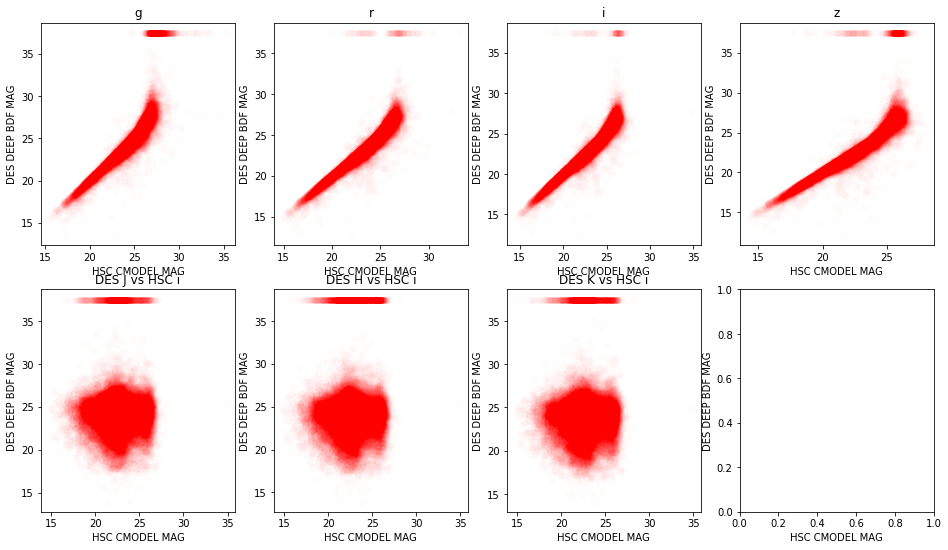

In [10]:
fig, axarr = plt.subplots(2, 4, figsize=(16,9), )#sharey=True, sharex=True)
select = deep_output['mag_DES_DEEP_' + 'g'] > 0
select2 = deep_output['mag_DES_DEEP_' + 'J'] > 0

axarr[0,0].plot(deep_output[select]['g_cmodel_mag'], deep_output[select]['mag_DES_DEEP_' + 'g'], 'ro', alpha=0.01)
axarr[0,1].plot(deep_output[select]['r_cmodel_mag'], deep_output[select]['mag_DES_DEEP_' + 'r'], 'ro', alpha=0.01)
axarr[0,2].plot(deep_output[select]['i_cmodel_mag'], deep_output[select]['mag_DES_DEEP_' + 'i'], 'ro', alpha=0.01)
axarr[0,3].plot(deep_output[select]['z_cmodel_mag'], deep_output[select]['mag_DES_DEEP_' + 'z'], 'ro', alpha=0.01)

axarr[1,0].plot(deep_output[select2]['i_cmodel_mag'], deep_output[select2]['mag_DES_DEEP_' + 'J'], 'ro', alpha=0.01)
axarr[1,1].plot(deep_output[select2]['i_cmodel_mag'], deep_output[select2]['mag_DES_DEEP_' + 'H'], 'ro', alpha=0.01)
axarr[1,2].plot(deep_output[select2]['i_cmodel_mag'], deep_output[select2]['mag_DES_DEEP_' + 'K'], 'ro', alpha=0.01)

for i, band in zip([0,1,2,3],['g','r','i','z']):
    axarr[0, i].set_title(band)
    axarr[0, i].set_ylabel('DES DEEP BDF MAG')
    axarr[0, i].set_xlabel('HSC CMODEL MAG')
    axarr[1, i].set_xlabel('HSC CMODEL MAG')
    axarr[1, i].set_ylabel('DES DEEP BDF MAG')
    
for i, band in zip([0,1,2],['J','H','K',]):  
    axarr[1, i].set_title('DES ' + band + ' vs HSC i')

In [11]:
fitsio.write(outfile, deep_output)
print('write ' + outfile)

write /global/cfs/projectdirs/des/jmyles/sompz_desc/hsc_deep_incl_nir_incl_specz_TEST_ONLY_NO_SCIENCE_2023-10-17.fits


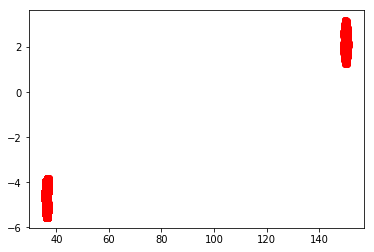

In [12]:
plt.figure()
plt.plot(deep_output[select]['ra'], deep_output[select]['dec'],'ro')